In [3]:
! ls RegMz* >mz_fft.txt

In [5]:
!cat mz_fft.txt

RegMz_10_j_0.22918311805232927_beta_0.hdf5
RegMz_10_j_0.22918311805232927_beta_1.5.hdf5
RegMz_10_j_0.22918311805232927_beta_2.5.hdf5
RegMz_10_j_0.22918311805232927_beta_inf.hdf5
RegMz_10_j_0.6366197723675814_beta_0.hdf5
RegMz_10_j_0.6366197723675814_beta_1.5.hdf5
RegMz_10_j_0.6366197723675814_beta_2.5.hdf5
RegMz_10_j_0.6366197723675814_beta_inf.hdf5
RegMz_8_j_0.22918311805232927_beta_0.hdf5
RegMz_8_j_0.22918311805232927_beta_1.5.hdf5
RegMz_8_j_0.22918311805232927_beta_2.5.hdf5
RegMz_8_j_0.22918311805232927_beta_inf.hdf5
RegMz_8_j_0.6366197723675814_beta_0.hdf5
RegMz_8_j_0.6366197723675814_beta_1.5.hdf5
RegMz_8_j_0.6366197723675814_beta_2.5.hdf5
RegMz_8_j_0.6366197723675814_beta_inf.hdf5
RegMz_6_j_0.22918311805232927_beta_0.hdf5
RegMz_6_j_0.22918311805232927_beta_1.5.hdf5
RegMz_6_j_0.22918311805232927_beta_2.5.hdf5
RegMz_6_j_0.22918311805232927_beta_inf.hdf5
RegMz_6_j_0.6366197723675814_beta_0.hdf5
RegMz_6_j_0.6366197723675814_beta_1.5.hdf5
RegMz_6_j_0.6366197723675814_beta_2.5.hdf5
Reg

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:15<00:00,  1.86it/s]


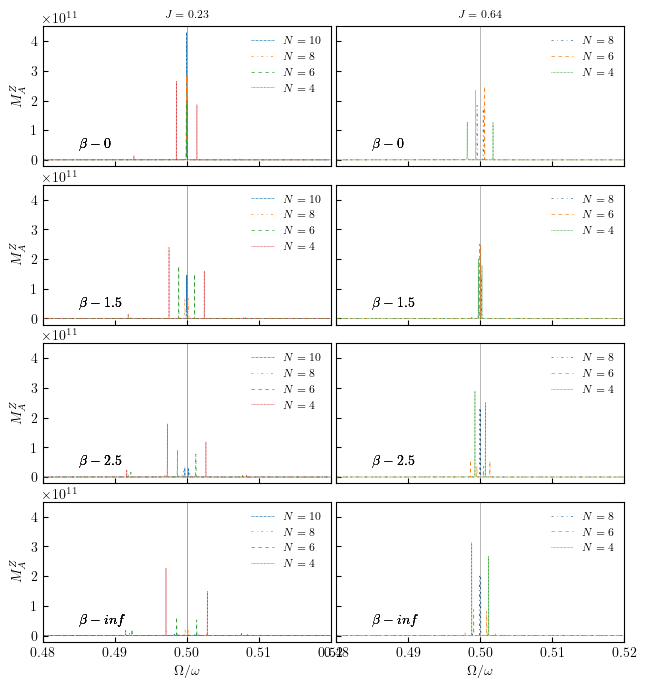

CPU times: user 50.4 s, sys: 3.81 s, total: 54.2 s
Wall time: 55.6 s


In [2]:
%%time
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import find_peaks
from lmfit.models import LinearModel
from tqdm import tqdm

plt.rcParams.update({"figure.figsize": (7.5,8),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 10,"font.sans-serif": ["Helvetica"]})
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),
     ('dashed',                (0, (5, 5))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

fig, axs = plt.subplots(4, 2, sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.02, hspace=0.13)


freq_threshold = 0.1
legendftsize = 8

omega = 20.0
w = omega
T = 2 * np.pi/w


with open("mz_fft.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    #btfr = np.zeros((2,4))
    
    btfr = np.zeros((4,2,4))
    betas = np.zeros((4,4))
    Ns = np.zeros((4,2,4))
    
    for xx in tqdm(range(0,x)):
        filename = lines[xx][:-1]
        #print(filename)
        
        with h5py.File(filename, "r") as f:
            mz_data_a = f['mza'][()]
            mz_data_b = f['mzb'][()]
            times = f['times'][()]            
            beta = f.attrs['beta']
            Jvalue = f.attrs['Jvalue']              
            N = f.attrs['N']
            w = f.attrs['w']
            
            T = 2 * np.pi/w
            
            if Jvalue == 0.072/T:
                jj = 0
                Jvalue1 = Jvalue
            if Jvalue == 0.2/T:
                jj = 1
                Jvalue2 = Jvalue
                
            infbeta = float('inf')
            
            if beta ==0:
                b = 0
            if beta ==1.5:
                b = 1
            if beta ==2.5:
                b = 2            
            if beta ==infbeta:
                b = 3
                
            if N == 4:
                n = 0
            if N == 6:
                n = 1
            if N == 8:   
                n = 2        
            if N == 10:
                n = 3
            '''
            if N == 12:
                n = 4         
            '''

            #-------  FFT   ----------------------------------------------------------------
            
            
            frequencies = T * np.fft.fftfreq(mz_data_a.size, d = times[-1]/len(times))
            fft_values = np.fft.fft(mz_data_a - np.average(mz_data_a))
            
            mask = frequencies > freq_threshold
            y = np.abs(fft_values[mask])**2
            x = frequencies[mask]
            
            line, = axs[b][jj].plot(x, y,linewidth=0.5,label = fr'$N={N}$', linestyle = linestyle_tuple[n][1])
            axs[b][jj].axvline(x=0.5, color = 'black',alpha = 0.1, linewidth=0.7)            
            
             #-------  Find FFT Peaks and Beats frequencies   ----------------------------------------------------------------
                
            peak_idx, peak_props = find_peaks(y, prominence = 5, distance = None)
            peak_pos = x[peak_idx]                     
            
            peaks_before = peak_pos[peak_pos < 0.5]
            before_proms = peak_props['prominences'][peak_pos < 0.5]
            most_prominent_idx = np.argmax(before_proms)
            prominent_freq_before = peaks_before[most_prominent_idx]

            peaks_after = peak_pos[peak_pos > 0.5]
            after_proms = peak_props['prominences'][peak_pos > 0.5]
            most_prominent_idx = np.argmax(after_proms)
            prominent_freq_after = peaks_after[most_prominent_idx]
            beat_freq = np.abs(prominent_freq_after-prominent_freq_before) 
            betas[jj][b] = beta
            
           
            if N == 4:
                btfr[0][jj][b] = beat_freq
                Ns[0][jj][b] = N
            if N == 6:
                btfr[1][jj][b] = beat_freq
                Ns[1][jj][b] = N
            if N == 8:
                btfr[2][jj][b] = beat_freq
                Ns[2][jj][b] = N  
            if N == 10:
                btfr[3][jj][b] = beat_freq
                Ns[3][jj][b] = N
            '''
            if N == 12:
                btfr[1][jj][b] = beat_freq  
                Ns[3][jj][b] = N     
            '''
            #print('N-',N, 'beta-',beta, 'jval-', Jvalue, 'jj',jj, 'b',b)            
            
            axs[b][jj].tick_params(which='both', axis="x", direction="in")
            axs[b][jj].tick_params(which='both', axis="y", direction="in")
            axs[b][jj].set_xlim(0.485,.515)
            #axs[b][jj].set_xlim(0,1)
            #axs[b][jj].set_ylim(bottom = 0.01)
            #axs[b][jj].set_yscale('log')
            axs[b][jj].legend(fontsize = legendftsize, frameon = False)
            axs[b][jj].text(0.485, 4e10, fr"$\beta-{beta}$", fontsize= 10)            
            axs[b][0].set_ylabel(r"$M^Z_A$")   
            axs[-1][jj].set_xlabel(r"$\Omega/\omega$")
            axs[-1][jj].set_xticks([0.48, 0.49,.5,.51,.52])        
               

'''        
for i in range(4):
    beta = betas[i]
    axs[-1].plot(Ns, btfr[i], label = fr"$\beta = {beta}$")
    axs[-1].scatter(Ns, btfr[i])
    
axs[-1].set_xticks([8,10,12])
axs[-1].set_xlabel(r"$N$")    
axs[-1].set_ylabel("Beat freq") 
axs[-1].legend(frameon =False, loc = 6, fontsize = 12) 

'''
axs[0][0].set_title(fr"$J={Jvalue1:2.2f}$", fontsize = legendftsize)
axs[0][1].set_title(fr"$J={Jvalue2:2.2f}$", fontsize = legendftsize)


figname = 'regional_mag_FFT_strong.pdf'
figname1 = 'regional_mag_FFT_strong.jpg'
plt.savefig(figname, bbox_inches='tight', pad_inches=0.0)
#plt.savefig(figname1, bbox_inches='tight', pad_inches=0.0, dpi=300)

plt.show()

In [3]:
btfr

array([[[2.85000143e-03, 4.90000245e-03, 5.35000268e-03, 5.75000288e-03],
        [3.55000178e-03, 5.00000250e-04, 1.45000073e-03, 2.35000118e-03]],

       [[1.00000050e-04, 2.20000110e-03, 2.55000128e-03, 2.80000140e-03],
        [1.25000063e-03, 1.50000075e-04, 2.70000135e-03, 1.80000090e-03]],

       [[5.00000250e-05, 5.00000250e-04, 8.50000425e-04, 4.50000225e-04],
        [8.50000425e-04, 4.00000200e-04, 1.00000050e-04, 1.50000075e-04]],

       [[3.61650181e-01, 5.00000250e-05, 5.00000250e-04, 5.01675251e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])

In [4]:
Ns

array([[[ 4.,  4.,  4.,  4.],
        [ 4.,  4.,  4.,  4.]],

       [[ 6.,  6.,  6.,  6.],
        [ 6.,  6.,  6.,  6.]],

       [[ 8.,  8.,  8.,  8.],
        [ 8.,  8.,  8.,  8.]],

       [[10., 10., 10., 10.],
        [ 0.,  0.,  0.,  0.]]])

## FFT beat frequency change with system size

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:15<00:00,  2.04it/s]


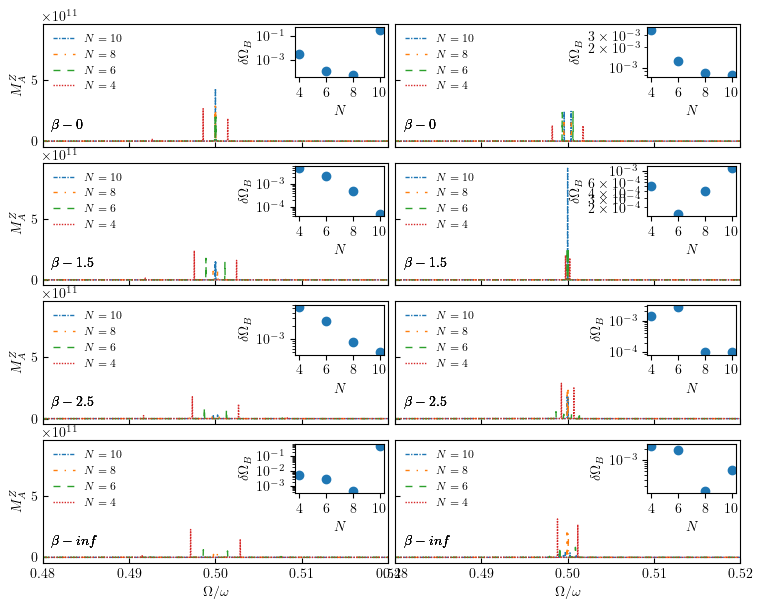

CPU times: user 21.8 s, sys: 3.24 s, total: 25 s
Wall time: 27 s


In [1]:
%%time
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import find_peaks
from lmfit.models import LinearModel
from tqdm import tqdm

plt.rcParams.update({"figure.figsize": (9,7),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 10,"font.sans-serif": ["Helvetica"]})
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),
     ('dashed',                (0, (5, 5))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

fig, axs = plt.subplots(4, 2, sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.02, hspace=0.13)




freq_threshold = 0.1
legendftsize = 8

omega = 20.0
w = omega
T = 2 * np.pi/w


with open("mz_fft.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    #btfr = np.zeros((2,4))
    
    btfr = np.zeros((4,2,4))
    betas = np.zeros((4,4))
    Ns = np.zeros((4,2,4))
    
    for xx in tqdm(range(0,x)):
        filename = lines[xx][:-1]
        #print(filename)
        
        with h5py.File(filename, "r") as f:
            mz_data_a = f['mza'][()]
            mz_data_b = f['mzb'][()]
            times = f['times'][()]            
            beta = f.attrs['beta']
            Jvalue = f.attrs['Jvalue']              
            N = f.attrs['N']
            w = f.attrs['w']
            
            T = 2 * np.pi/w
            
            if Jvalue == 0.072/T:
                jj = 0
                Jvalue1 = Jvalue
            if Jvalue == 0.2/T:
                jj = 1
                Jvalue2 = Jvalue
                
            infbeta = float('inf')            
            if beta ==0:
                b = 0
            if beta ==1.5:
                b = 1
            if beta ==2.5:
                b = 2            
            if beta ==infbeta:
                b = 3
                
            if N == 4:
                n = 0
            if N == 6:
                n = 1
            if N == 8:   
                n = 2        
            if N == 10:
                n = 3
            '''
            if N == 12:
                n = 4         
            '''

            #-------  FFT   ----------------------------------------------------------------
            
            
            frequencies = T * np.fft.fftfreq(mz_data_a.size, d = times[-1]/len(times))
            fft_values = np.fft.fft(mz_data_a - np.average(mz_data_a))
            
            mask = frequencies > freq_threshold
            y = np.abs(fft_values[mask])**2
            x = frequencies[mask]
            
            line, = axs[b][jj].plot(x, y,linewidth=1,label = fr'$N={N}$', linestyle = linestyle_tuple[n][1])
            #axs[b][jj].axvline(x=0.5, color = 'black',alpha = 0.1, linewidth=0.5)            
            
             #-------  Find FFT Peaks and Beats frequencies   ----------------------------------------------------------------
                
            peak_idx, peak_props = find_peaks(y, prominence = 5, distance = None)
            peak_pos = x[peak_idx]                     
            
            peaks_before = peak_pos[peak_pos < 0.5]
            before_proms = peak_props['prominences'][peak_pos < 0.5]
            most_prominent_idx = np.argmax(before_proms)
            prominent_freq_before = peaks_before[most_prominent_idx]

            peaks_after = peak_pos[peak_pos > 0.5]
            after_proms = peak_props['prominences'][peak_pos > 0.5]
            most_prominent_idx = np.argmax(after_proms)
            prominent_freq_after = peaks_after[most_prominent_idx]
            beat_freq = np.abs(prominent_freq_after-prominent_freq_before) 
            betas[jj][b] = beta
            
           
            if N == 4:
                btfr[0][jj][b] = beat_freq
                Ns[0][jj][b] = N
            if N == 6:
                btfr[1][jj][b] = beat_freq
                Ns[1][jj][b] = N
            if N == 8:
                btfr[2][jj][b] = beat_freq
                Ns[2][jj][b] = N  
            if N == 10:
                btfr[3][jj][b] = beat_freq
                Ns[3][jj][b] = N
            '''
            if N == 12:
                btfr[1][jj][b] = beat_freq  
                Ns[3][jj][b] = N     
            '''
            #print('N-',N, 'beta-',beta, 'jval-', Jvalue, 'jj',jj, 'b',b)            
            
            axs[b][jj].tick_params(which='both', axis="x", direction="in")
            axs[b][jj].tick_params(which='both', axis="y", direction="in")
            axs[b][jj].set_xlim(0.485,.515)
            #axs[b][jj].set_xlim(0,1)
            #axs[b][jj].set_ylim(bottom = 0.01)
            #axs[b][jj].set_yscale('log')
            axs[b][jj].legend(fontsize = legendftsize, frameon = False, loc =2)
            axs[b][jj].text(0.481, 1e11, fr"$\beta-{beta}$", fontsize= 10)            
            axs[b][0].set_ylabel(r"$M^Z_A$")   
            axs[-1][jj].set_xlabel(r"$\Omega/\omega$")
            axs[-1][jj].set_xticks([0.48, 0.49,.5,.51,.52])     
            
            
            
for jj in range(2):
    for b in range(4):
        left, bottom, width, height = [0.8, 0.75, 0.43, 0.9]
        inset = inset_axes(axs[b][jj], width="60%", height="45%",loc = "upper right",\
                              bbox_to_anchor=([left, bottom, width, height]),\
                              bbox_transform=axs[b][jj].transAxes, borderpad=6)
        nst = Ns.T
        btfrt = btfr.T
        inset.scatter(nst[b][jj], btfrt[b][jj])
        inset.set_xlabel('$N$')
        inset.set_ylabel('$\delta \Omega_B$')        
        inset.set_yscale('log')
        inset.set_yscale('log')
        inset.set_xticks(nst[b][jj])


figname = 'regional_mag_FFT_strong.pdf'
figname1 = 'regional_mag_FFT_strong.jpg'
plt.savefig(figname, bbox_inches='tight', pad_inches=0.0)
#plt.savefig(figname1, bbox_inches='tight', pad_inches=0.0, dpi=300)

plt.show()

In [3]:
btfr

array([[[2.85000143e-03, 4.90000245e-03, 5.35000268e-03, 5.75000288e-03],
        [3.55000178e-03, 5.00000250e-04, 1.45000073e-03, 2.35000118e-03]],

       [[1.00000050e-04, 2.20000110e-03, 2.55000128e-03, 2.80000140e-03],
        [1.25000063e-03, 1.50000075e-04, 2.70000135e-03, 1.80000090e-03]],

       [[5.00000250e-05, 5.00000250e-04, 8.50000425e-04, 4.50000225e-04],
        [8.50000425e-04, 4.00000200e-04, 1.00000050e-04, 1.50000075e-04]],

       [[3.61650181e-01, 5.00000250e-05, 5.00000250e-04, 5.01675251e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])

In [14]:
btfrt = btfr.T
btfrt

array([[[2.85000143e-03, 1.00000050e-04, 5.00000250e-05, 3.61650181e-01],
        [3.55000178e-03, 1.25000063e-03, 8.50000425e-04, 0.00000000e+00]],

       [[4.90000245e-03, 2.20000110e-03, 5.00000250e-04, 5.00000250e-05],
        [5.00000250e-04, 1.50000075e-04, 4.00000200e-04, 0.00000000e+00]],

       [[5.35000268e-03, 2.55000128e-03, 8.50000425e-04, 5.00000250e-04],
        [1.45000073e-03, 2.70000135e-03, 1.00000050e-04, 0.00000000e+00]],

       [[5.75000288e-03, 2.80000140e-03, 4.50000225e-04, 5.01675251e-01],
        [2.35000118e-03, 1.80000090e-03, 1.50000075e-04, 0.00000000e+00]]])

In [3]:
nst = Ns.T
nst

array([[[ 4.,  6.,  8., 10.],
        [ 4.,  6.,  8.,  0.]],

       [[ 4.,  6.,  8., 10.],
        [ 4.,  6.,  8.,  0.]],

       [[ 4.,  6.,  8., 10.],
        [ 4.,  6.,  8.,  0.]],

       [[ 4.,  6.,  8., 10.],
        [ 4.,  6.,  8.,  0.]]])

In [6]:
nst[0][1]

array([4., 6., 8., 0.])

# Check the time evolution data

localmz_N8_J_0.6366197723675814.hdf5 0
localmz_N10_J_0.6366197723675814.hdf5 1
localmz_N12_J_0.6366197723675814.hdf5 2


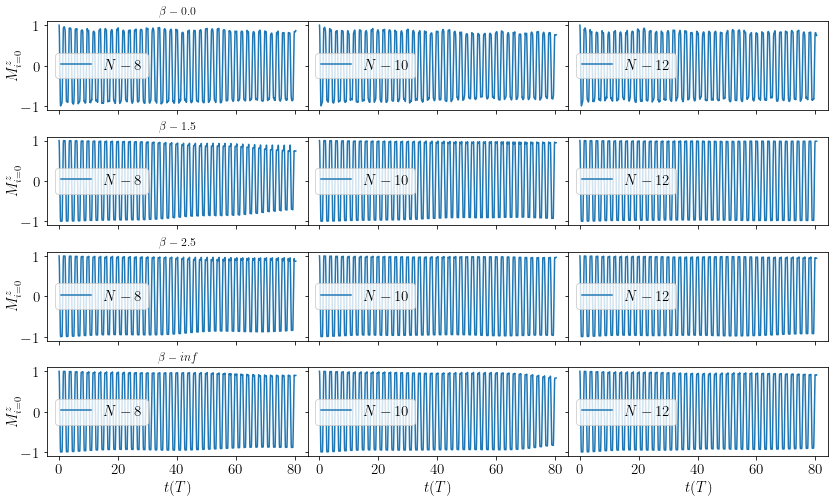

In [114]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import find_peaks
from lmfit.models import LinearModel

plt.rcParams.update({"figure.figsize": (14, 8),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),
     ('dashed',                (0, (5, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

fig, axs = plt.subplots(4, 3, sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.0, hspace=0.3)

steps = 20001
freq_threshold = 0.1
legendftsize = 12

omega = 20.0
w = omega
T = 2 * np.pi/w


Ns = []
site = 0


with open("regional_mz_fft.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    btfr = np.zeros((4,x))
    
    for xx in range(0,x):
        filename = lines[xx][:-1]
        print(filename, xx)
        
        with h5py.File(filename, "r") as f:
            datas = f['mz'][()]
            times = f['times'][()]
            betas = f['betas'][()]
            N = f.attrs['N']
            Jvalue = f.attrs['Jvalue']   
            

        
        for b, beta in enumerate(betas):
            
            datap = np.zeros((N, len(times)))
            datap = datas[b][site][0]
        
            axs[b][0].set_title(fr"$\beta-{beta}$", fontsize=12)
            axs[b][xx].plot(times * 80/25, datap, label = fr"$N-{N}$")
            axs[b][xx].legend(loc = 6)
            



[axs[-1][i].set_xlabel('$t (T)$') for i in range(3)]
[axs[i][0].set_ylabel('$M^z_{i=0}$', labelpad =0) for i in range(4)]
            
            
#figname = 'regional_mag_FFT_strong.pdf'
figname1 = 'regional_mag_timeevolution_strong.jpg'
#plt.savefig(figname, bbox_inches='tight', pad_inches=0.0)
plt.savefig(figname1, bbox_inches='tight', pad_inches=0.0, dpi=300)
plt.show()